# CSE 252B: Computer Vision II, Winter 2019 – Assignment 1
### Instructor: Ben Ochoa
### Due: Wednesday, January 16, 2019, 11:59 PM

## Instructions
* Review the academic integrity and collaboration policies on the course website.
* This assignment must be completed individually.
* This assignment contains both math and programming problems.
* All solutions must be written in this notebook
* Math problems must be done in Markdown/LATEX. Remember to show work and describe your solution.
* Programming aspects of this assignment must be completed using Python in this notebook.
* This notebook contains skeleton code, which should not be modified (This is important for standardization to facilate effeciant grading).
* You may use python packages for basic linear algebra, but you may not use packages that directly solve the problem. Ask the instructor if in doubt.
* You must submit this notebook exported as a pdf. You must also submit this notebook as an .ipynb file.
* You must submit both files (.pdf and .ipynb) on Gradescope. You must mark each problem on Gradescope in the pdf.
* It is highly recommended that you begin working on this assignment early.

# Problem 1 (Programming): Feature detection (20 points)
Download input data from the course website. The file price_center20.JPG
contains image 1 and the file price_center21.JPG contains image 2. 

For each input image, calculate an image where each pixel value is the minor
eigenvalue of the gradient matrix

$N=\left[ \begin{array}{cc}
\sum\limits_w I_x^2 & \sum\limits_w I_x I_y\\
\sum\limits_w I_x I_y & \sum\limits_w I_y^2
\end{array} \right]$

where w is the window about the pixel, and $I_x$ and $I_y$ are the gradient images in
the x and y direction, respectively. Calculate the gradient images using the fivepoint
central difference operator. Set resulting values that are below a specified
threshold value to zero (hint: calculating the mean instead of the sum in N allows
for adjusting the size of the window without changing the threshold value). Apply
an operation that suppresses (sets to 0) local (i.e., about a window) nonmaximum
pixel values in the minor eigenvalue image. Vary these parameters such that
around 600–650 features are detected in each image. For resulting nonzero pixel
values, determine the subpixel feature coordinate using the Forstner corner point
operator.

#### Report your final values for:
 * the size of the feature detection window (i.e. the size of the window used to calculate the elements in the gradient matrix N)
 * the minor eigenvalue threshold value 
 * the size of the local nonmaximum suppression window 
 * the resulting number of features detected (i.e. corners) in each image.

#### Display figures for:
 * gradient image heat map before thresholding
 * gradient image heat map after thresholding
 * original image with detected features

My implementation takes around 25 seconds to run. If yours is more than 250 seconds you may lose points.

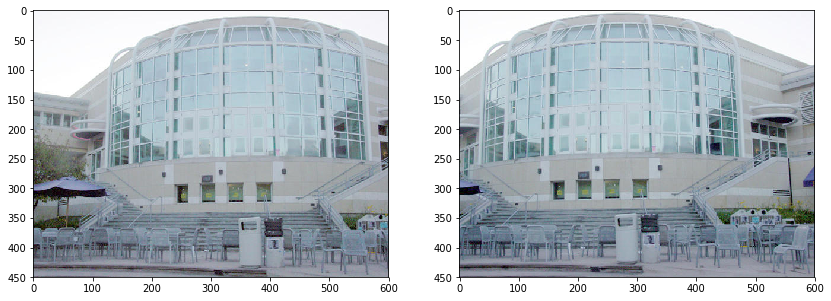

In [8]:
%matplotlib inline
import numpy as np
from PIL import Image
from scipy.signal import convolve2d as conv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time


# open the input images
I1 = np.array(Image.open('price_center20.JPG'), dtype='float')/255.
I2 = np.array(Image.open('price_center21.JPG'), dtype='float')/255.

# Display the input images
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(I1)
plt.subplot(1,2,2)
plt.imshow(I2)
plt.show()

In [11]:
def ImageGradient(I, w, t):
    # inputs: 
    # I is the input image (may be mxn for Grayscale or mxnx3 for RGB)
    # w is the size of the window used to compute the gradient matrix N
    # t is the minor eigenvalue threshold
    #
    # outputs:
    # N is the 2x2xmxn gradient matrix
    # b in the 2x1xmxn vector used in the Forstner corner detector
    # J0 is the mxn minor eigenvalue image of N before thresholding
    # J1 is the mxn minor eigenvalue image of N after thresholding
    
    m,n = I.shape[:2]
    N = np.zeros((2,2,m,n))
    b = np.zeros((2,1,m,n))
    J0 = np.zeros((m,n))

    
    """your code here"""
    gradient_operator_conv = np.array([-1, 8, 0, -8, 1])
    gradient_operator_conv_x = gradient_operator_conv[None, :] # hori
    gradient_operator_conv_y = gradient_operator_conv[:, None] # vert
    
    grid = np.indices(I.shape)
    row_y = grid[0]
    col_x = grid[1]
    
    Ix = conv2(I, gradient_operator_conv_x, 'same', 'symm') # input, kernel
    Iy = conv2(I, gradient_operator_conv_y, 'same', 'symm')
    IxIx = Ix * Ix
    IyIy = Iy * Iy
    IxIy = Ix * Iy

    
    xIxIx = col_x * IxIx
    yIyIy = row_y * IyIy
    xIxIy = col_x * IxIy
    yIxIy = row_y * IxIy
    
    window_sum_kernel = np.ones((w, w))
    num_elements = w * w
    
    window_sum_IxIx = conv2(IxIx, window_sum_kernel, 'same', 'symm') / num_elements
    window_sum_IyIy = conv2(IyIy, window_sum_kernel, 'same', 'symm') / num_elements
    window_sum_IxIy = conv2(IxIy, window_sum_kernel, 'same', 'symm') / num_elements
    
    window_sum_xIxIx = conv2(xIxIx, window_sum_kernel, 'same', 'symm') / num_elements
    window_sum_yIyIy = conv2(yIyIy, window_sum_kernel, 'same', 'symm') / num_elements
    window_sum_xIxIy = conv2(xIxIy, window_sum_kernel, 'same', 'symm') / num_elements
    window_sum_yIxIy = conv2(yIxIy, window_sum_kernel, 'same', 'symm') / num_elements
    
    
    for i in range(m):
        for j in range(n):
            cov = np.array([[window_sum_IxIx[i][j], window_sum_IxIy[i][j]],\
                            [window_sum_IxIy[i][j], window_sum_IyIy[i][j]]])
            N[:, :, i, j] = cov
            b[:, :, i, j] = np.array([[window_sum_xIxIx[i][j] + window_sum_yIxIy[i][j]],\
                                      [window_sum_xIxIy[i][j] + window_sum_yIyIy[i][j]]])
            lmbds, egnvctrs = np.linalg.eig(cov)
            J0[i][j] = min(lmbds)

                
    J1 = np.copy(J0)
    J1[J1 < t] = 0

    return N, b, J0, J1
  

    
    
def NMS(J, w_nms):
    # Apply nonmaximum supression to J using window w
    # For any window in J, the result should only contain 1 nonzero value
    # In the case of multiple identical maxima in the same window,
    # the tie may be broken arbitrarily
    #
    # inputs: 
    # J is the minor eigenvalue image input image after thresholding
    # w_nms is the size of the local nonmaximum suppression window
    # 
    # outputs:
    # J2 is the mxn resulting image after applying nonmaximum suppression
    # 
    
    
#     half_w_nms = int((w_nms-1)/2)
#     for i in range(half_w_nms,m-half_w_nms):
#         for j in range(half_w_nms,n-half_w_nms):
#             window = J1[i-half_w_nms:i+half_w_nms,j-half_w_nms:j+half_w_nms]
#             local_max = np.amax(window)
#             if J1[i,j]==local_max:
#                 J2[i,j]=J1[i,j]
    
    
    J2 = J.copy()
    """your code here"""
    w_nms_center = int((w_nms - 1) / 2)
    
    for i in range(w_nms_center, J.shape[0] - w_nms_center):
        for j in range(w_nms_center, J.shape[1] - w_nms_center):
            
            patch_J = J[i - w_nms_center: i + w_nms_center + 1,\
                        j - w_nms_center: j + w_nms_center + 1]
            local_max = np.max(patch_J)
            
            mask = patch_J < local_max
            patch_J2 = J2[i - w_nms_center: i + w_nms_center + 1,\
                          j - w_nms_center: j + w_nms_center + 1]
            
            patch_J2[mask] = 0 # nonmaximum suppression
   
    return J2
  

def ForstnerCornerDetector(J, N, b):
    # Gather the coordinates of the nonzero pixels in J 
    # Then compute the sub pixel location of each point using the Forstner operator
    #
    # inputs:
    # J is the NMS image
    # N is the 2x2xmxn gradient matrix
    # b is the 2x1xmxn vector computed in the image_gradient function
    #
    # outputs:
    # C is the number of corners detected in each image
    # pts is the 2xC list of coordinates of subpixel accurate corners
    #     found using the Forstner corner detector
    
    """your code here"""
    mask = J != 0
    C = np.sum(mask)
    pts = np.zeros((2,C))
    
    sub_Ns = N[:, :, mask]
    sub_bs = b[:, :, mask]
    for i in range(C):
        sub_N = sub_Ns[:, :, i]
        sub_b = sub_bs[:, :, i]
        pt= np.linalg.pinv(sub_N).dot(sub_b)
        pts[:, i] = np.squeeze(pt)
    
    
    pts = pts.astype('int')
    print(pts.shape)
    pts = np.unique(pts, axis=1)
    C = pts.shape[1]
    return C, pts


# feature detection
def RunFeatureDetection(I, w, t, w_nms):
    N, b, J0, J1 = ImageGradient(I, w, t)
    J2 = NMS(J1, w_nms)
    C, pts = ForstnerCornerDetector(J2, N, b)
    return C, pts, J0, J1, J2


(2, 255)
(2, 269)
took 23.699392 secs
C1 254
C2 268


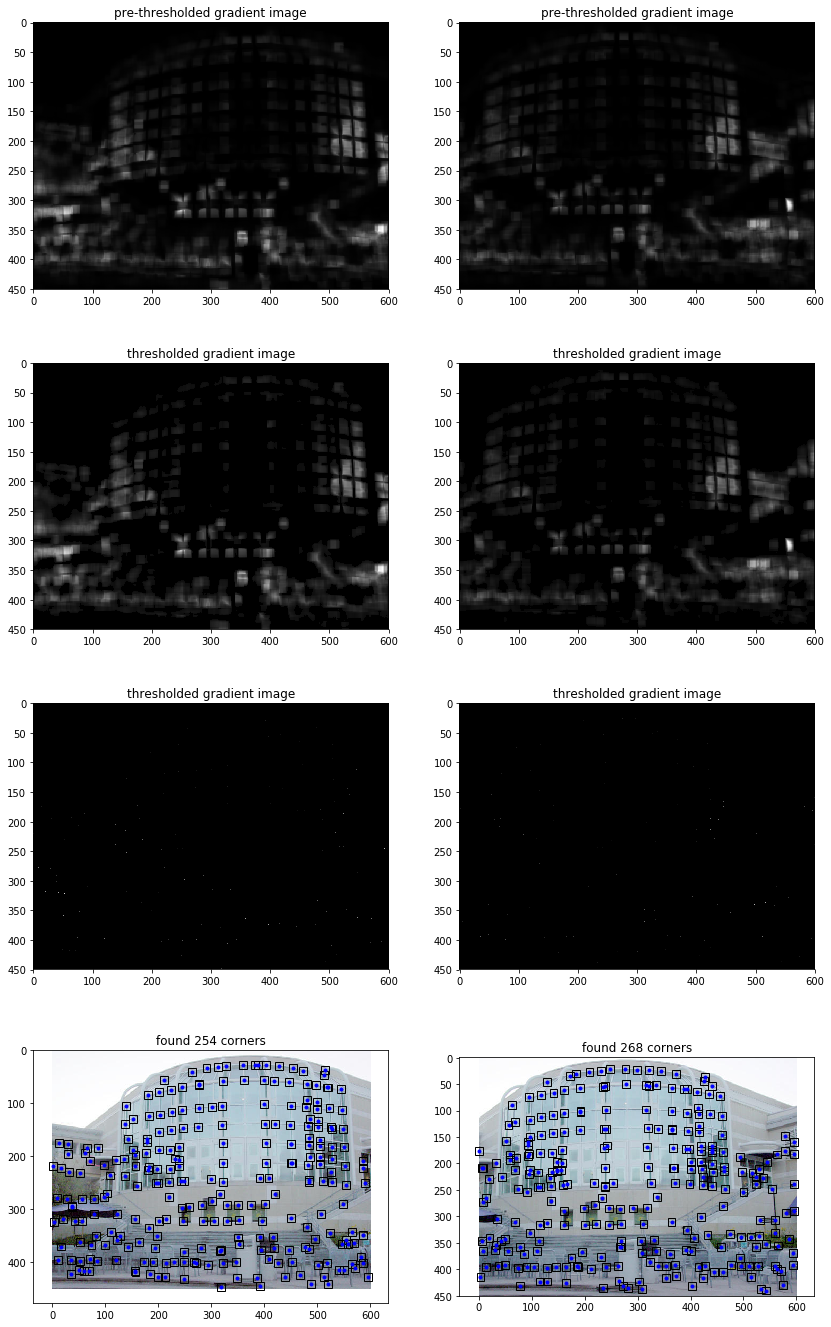

In [12]:
# input images
I1 = np.array(Image.open('price_center20.JPG'), dtype='float')/255.
I2 = np.array(Image.open('price_center21.JPG'), dtype='float')/255.

# parameters to tune
w = 15
t = 0.08
w_nms = 7

tic = time.time()
# run feature detection algorithm on input images
I1_grey = I1[...,:3].dot([0.299, 0.587, 0.114])
I2_grey = I2[...,:3].dot([0.299, 0.587, 0.114])

C1, pts1, J1_0, J1_1, J1_2 = RunFeatureDetection(I1_grey, w, t, w_nms)
C2, pts2, J2_0, J2_1, J2_2 = RunFeatureDetection(I2_grey, w, t, w_nms)
toc = time.time() - tic

print('took %f secs'%toc)
print('C1', C1)
print('C2', C2)

# display results
plt.figure(figsize=(14,24))

# show pre-thresholded corner heat map from gradient image function
plt.subplot(4,2,1)
plt.imshow(J1_0, cmap='gray')
plt.title('pre-thresholded gradient image')
plt.subplot(4,2,2)
plt.imshow(J2_0, cmap='gray')
plt.title('pre-thresholded gradient image')

# show thresholded corner heat map from gradient image function
plt.subplot(4,2,3)
plt.imshow(J1_1, cmap='gray')
plt.title('thresholded gradient image')
plt.subplot(4,2,4)
plt.imshow(J2_1, cmap='gray')
plt.title('thresholded gradient image')


# show thresholded corner heat map from gradient image function
plt.subplot(4,2,5)
plt.imshow(J1_2, cmap='gray')
plt.title('thresholded gradient image')
plt.subplot(4,2,6)
plt.imshow(J2_2, cmap='gray')
plt.title('thresholded gradient image')

# show corners on original images
ax = plt.subplot(4,2,7)
plt.imshow(I1)
for i in range(C1): # draw rectangles of size w around corners
    x,y = pts1[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
plt.plot(pts1[0,:], pts1[1,:], '.b') # display subpixel corners
plt.title('found %d corners'%C1)

ax = plt.subplot(4,2,8)
plt.imshow(I2)
for i in range(C2):
    x,y = pts2[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
plt.plot(pts2[0,:], pts2[1,:], '.b')
plt.title('found %d corners'%C2)

plt.show()

#### Final values for parameters
* w = 15
* t = 0.08
* w_nms = 7
* C1 = 254
* C2 = 268

## Problem 2 (Programming): Feature matching (15 points)
Determine the set of one-to-one putative feature correspondences by performing
a brute-force search for the greatest correlation coefficient value (in the range
[-1, 1]) between the detected features in image 1 and the detected features in
image 2. Only allow matches that are above a specified correlation coefficient
threshold value (note that calculating the correlation coefficient allows for adjusting
the size of the matching window without changing the threshold value).
Further, only allow matches that are above a specified distance ratio threshold
value, where distance is measured to the next best match for a given feature.
Vary these parameters such that around 200 putative feature correspondences are
established. Optional: constrain the search to coordinates in image 2 that are
within a proximity of the detected feature coordinates in image 1.

#### Report your final values for:
* the size of the matching window
* the correlation coefficient threshold
* the distance ratio threshold 
* the size of the proximity window (if used)
* the resulting number of putative feature correspondences (i.e. matched features)

#### Display figures for:
* pair of images, where the matched features in each of the images are indicated by a square window about the feature

My implementation takes around 40 seconds to run. If yours is more than 400 seconds you may lose points.


In [30]:
def NCC(I1, I2, pts1, pts2, w):
    # compute the normalized cross correlation between image patches I1, I2
    # result should be in the range [-1,1]
    #
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    #
    # output:
    # normalized cross correlation matrix of scores between all windows in 
    #    image 1 and all windows in image 2
    
    """your code here"""
    R = int((w - 1) / 2)
    I1_padded = np.pad(I1, pad_width = R, mode = 'constant', constant_values = 0)
    I2_padded = np.pad(I2, pad_width = R, mode = 'constant', constant_values = 0)
    W_I1 = np.zeros((w*w, pts1.shape[1]))
    W_I2 = np.zeros((w*w, pts2.shape[1]))
    
    for i, pt1 in enumerate(pts1.T):
        # row of array is y in image, and col of array is x in image
        I1_patch = I1_padded[(pt1[1]):(pt1[1]+2*R+1),\
                             (pt1[0]):(pt1[0]+2*R+1)]
        I1_patch_mean = np.mean(I1_patch)
        I1_patch_norm = np.sum((I1_patch - I1_patch_mean)**2)
        W_I1_i = (I1_patch - I1_patch_mean) / np.sqrt(I1_patch_norm)
        W_I1[:, i] = W_I1_i.ravel() # data matrix 1, window size * num_points
        


    for i, pt2 in enumerate(pts2.T):
        I2_patch = I2_padded[(pt2[1]):(pt2[1]+2*R+1),\
                             (pt2[0]):(pt2[0]+2*R+1)]
        I2_patch_mean = np.mean(I2_patch)
        I2_patch_norm = np.sum((I2_patch - I2_patch_mean)**2)
        W_I2_i = (I2_patch - I2_patch_mean) / np.sqrt(I2_patch_norm)
        W_I2[:, i] = W_I2_i.ravel() # data matrix 1, window size * num_points
        
    scores = W_I1.T.dot(W_I2) # W_I1 * W_I2
    return scores




def Match(scores, t, d, p, pts1, pts2):
    # perform the one-to-one correspondence matching on the correlation coefficient matrix
    # 
    # inputs:
    # scores is the NCC matrix
    # t is the correlation coefficient threshold
    # d distance ration threshold
    # p is the size of the proximity window
    #
    # output:
    # list of the feature coordinates in image 1 and image 2 
    
    """your code here"""
    #inds = np.vstack((np.random.choice(pts1.shape[1],200,replace=False), 
      #                np.random.choice(pts1.shape[1],200,replace=False)))
    masked_scores = scores.copy()
    feature_idx_I1 = []
    feature_idx_I2 = []
    
    mask = np.ones_like(scores).astype('bool') # initialize mask 
    
    while True:
        masked_scores[~mask] = -np.inf # masking scores
        
        # step1: find index of first maximum value in masked cross-correlation coefficient array
        first_max_idx = np.unravel_index(masked_scores.argmax(), masked_scores.shape) # W_I1 * W_I2
        
        # step2: store first maximum value
        first_max_scr = np.max(masked_scores)
        if t >= first_max_scr: break
            
        # step3: temporarily set that first maximum value to -1 in original scores array
        scores[first_max_idx] = -1
        
        # step4: find second maximum value and index, in the row which contains first maximum value (non masked)
        max_row_element = np.max(scores[first_max_idx[0], :])
        max_col_element = np.max(scores[:, first_max_idx[1]])
        
        second_max_scr = max(max_row_element, max_col_element)
        
        # step5: set the first maximum value back into original scores matrix
        scores[first_max_idx] = first_max_scr
        
        # step6: if (1 - Best Match) < (1 - next best match) * distance ratio threshold, then first is best match, store it
        # then pass to step 7
        if (1 - first_max_scr) < (1 - second_max_scr) * d:
            I1_pt = pts1[:, first_max_idx[0]]
            I2_pt = pts2[:, first_max_idx[1]]
            checkInProximityWindow = (abs(I2_pt[1] - I1_pt[1]) < p/2) and (abs(I2_pt[0] - I1_pt[0]) <= p/2)
            if checkInProximityWindow:
                feature_idx_I1.append(first_max_idx[0])
                feature_idx_I2.append(first_max_idx[1])
        # else it is not unique and pass to step 7

        # step7: using first maximum idx to set row and col of the mask false
        mask[first_max_idx[0], :] = False
        mask[:, first_max_idx[1]] = False
        
        
    inds = np.vstack((feature_idx_I1, feature_idx_I2)) # represent feature window idx
    return inds



def RunFeatureMatching(I1, I2, pts1, pts2, w, t, d, p):
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # t is the correlation coefficient threshold
    # d distance ration threshold
    # p is the size of the proximity window
    #
    # outputs:
    # inds is a 2xk matrix of matches where inds[0,i] indexs a point pts1 
    #     and inds[1,i] indexs a point in pts2, where k is the number of matches
    
    scores = NCC(I1, I2, pts1, pts2, w)
    inds = Match(scores, t, d, p, pts1, pts2) 
    return inds

took 0.080414 secs


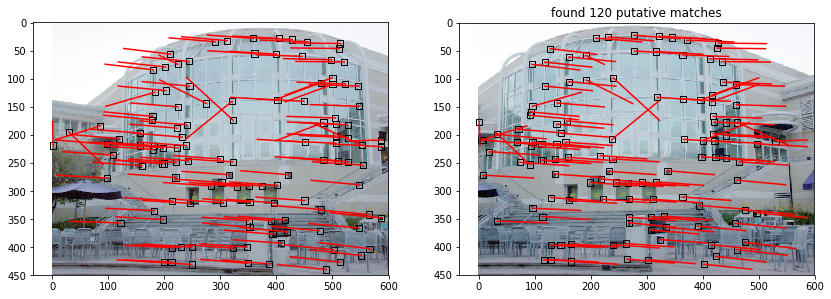

unique points in image 1: 120
unique points in image 2: 120


In [31]:
# parameters to tune
# w1 = 5
w1 = 11
t = 0.55
d = 1.05
# p = np.inf
p = 200  # 200 * 200 window, but use 200/2 as threshold

tic = time.time()
# run the feature matching algorithm on the input images and detected features
inds = RunFeatureMatching(I1_grey, I2_grey, pts1, pts2, w1, t, d, p)
toc = time.time() - tic

print('took %f secs'%toc)

# create new matrices of points which contain only the matched features 
match1 = pts1[:, inds[0,:]]
match2 = pts2[:, inds[1,:]]

# display the results
plt.figure(figsize=(14,24))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
plt.title('found %d putative matches'%match1.shape[1])
for i in range(match1.shape[1]):
    x1,y1 = match1[:,i]
    x2,y2 = match2[:,i]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w1/2,y1-w1/2),w1,w1, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w1/2,y2-w1/2),w1,w1, fill=False))

plt.show()

# test 1-1
print('unique points in image 1: %d'%np.unique(inds[0,:]).shape[0])
print('unique points in image 2: %d'%np.unique(inds[1,:]).shape[0])

#### Final values for parameters
* w = 11
* t = 0.55
* d = 1.05
* p = 200
* num_matches = 128